In [3]:
%matplotlib notebook

In [9]:
class constants():
    def __init__(self,):
        self.LHC_TURN_LENGTH = 8.892485213887535e-05
        self.ADC_FREQ = 650e6
        self.LHC_N_BUCKETS = 35640
cst = constants()
        


def morseDecay(x,A,B1,B2,C):
    return A*(1-(1-np.exp(-B1*(x-C)))*(1-np.exp(-B2*(x-C))))


def moyalDist(x,A,mu,sigma1,sigma2):
    return A*np.exp(-(x-mu)/(2*sigma1) - np.exp(-(x-mu)/sigma2)/2)/np.exp(-1/2)

def expDecay(x,A,mu,sigma):
    return A*np.exp(-sigma*(x-mu))



def VFCParser(content,turns=None):
    # Find the number of samples -> [sampleStart,sampleStop]
    samples = list((np.array(turns)*cst.LHC_TURN_LENGTH*cst.ADC_FREQ).astype(int)) if turns is not None else None

    # Extracting dataset for the desired period and time-reversing the array
    dataset = np.array(content['snapshot'][samples[0]:samples[1]],dtype=np.uint32,copy=False)
    dataInTime = dataset[::-1]
    
    
    # Get the raw ADC data (skip two bits, see Documentation)
    rawData = dataInTime >> 2
    # Generating the time vector
    time = 1/cst.ADC_FREQ * np.arange(len(rawData))
    # Get turn flags
    turnFlags = (dataInTime & 0x2) >> 1
    # get bunch flags
    bunchFlags = dataInTime & 0x1
    
    return time,rawData,turnFlags,bunchFlags


def getGaps(data,bunchFlags,turnFlags,stdThreshold=50):
    # Sum up all the signal turn by turn to put emphasis on the filling pattern
    turnFlagsIndex = np.arange(len(data))[turnFlags.astype(bool)]
    forcedLength = np.min(np.diff(turnFlagsIndex))
    fillSignal = sum([turnSignal[:forcedLength] for turnSignal in np.split(data,turnFlagsIndex)[1:-1]])

    # Computing the standard deviation over each bunch flag bin
    bunchFlagsIndex = np.arange(len(fillSignal))[bunchFlags[:forcedLength].astype(bool)]
    bunchBinSTD = np.array([np.std(subsection) for subsection in np.split(fillSignal,bunchFlagsIndex)][1:])

    # Returning the index of empty bins in the data (gaps) from threshold
    #bunchFlagsIndex = np.concatenate((np.array([0]),bunchFlagsIndex))
    emptyBins = bunchBinSTD<stdThreshold
    return bunchFlagsIndex[emptyBins]

def signalBaseline(t,data,bunchFlags,turnFlags,stdThreshold=40):
    # Computing the index of the gaps in relation to the turn clock
    gapIndex = getGaps(data,bunchFlags,turnFlags,stdThreshold=stdThreshold)

    # Extending the gap indices on the full data set (repeat them every turn)
    bunchFlagsIndex = np.arange(len(data))[bunchFlags.astype(bool)]
    turnFlagsIndex = np.arange(len(data))[turnFlags.astype(bool)]
    allGaps = np.repeat(turnFlagsIndex[:-1],len(gapIndex)) + np.tile(gapIndex,len(turnFlagsIndex[:-1]))

    # Return either the signal (empty bin) or interpolated baseLine (non-empty bin) when splitting over gaps
    binLength = np.max(np.diff(bunchFlagsIndex))
    baseLine = [subsection if len(subsection)<3*binLength else np.interp(np.arange(len(subsection)),[0,len(subsection)],[subsection[0],subsection[-1]]) for subsection in np.split(rawData,allGaps)]

    # Force baseLine==data for the last turn since it must be discarded
    baseLine = np.concatenate(baseLine)
    baseLine[turnFlagsIndex[-1]:] = data[turnFlagsIndex[-1]:]
    
    return baseLine
    

def fitBunch(x,y,nPoints = 500,skipRisingPoint = 0,skipFallingPoint = 0):
    # Getting the index of the rising part (Moyal distribution) and the falling part (Exponential)
    riseIndex = skipRisingPoint + np.argmax(np.diff(np.diff(y))) + 2
    fallIndex = skipFallingPoint + np.argmax(y) + 5
    
    # Re-scaling the data to help the fitting tool
    x0 = x[0]
    scaling = 10**(-int(np.log10(x[-1]-x[0])))
    x = scaling*(x-x0)
    xSpacing = np.mean(np.diff(x))
    
    # Fitting Moyal distribution
    xTemp = x[riseIndex:]
    yTemp = y[riseIndex:]
    p0Guess = [np.max(yTemp),xTemp[np.argmax(yTemp)],1,1]
    lowBound = [0.1*p0Guess[0],p0Guess[1]-5*xSpacing,1e-2,1e-2]
    highBound = [10*p0Guess[0],p0Guess[1]+5*xSpacing,1e2,1e2]
    poptMoyal,_ = so.curve_fit(moyalDist, xTemp, yTemp, p0=p0Guess,bounds=(lowBound, highBound))
   
    # Fitting the expontential
    xTemp = x[fallIndex:]
    yTemp = y[fallIndex:]
    p0Guess = [np.max(yTemp),xTemp[np.argmax(yTemp)],1]
    lowBound = [0.5*p0Guess[0],p0Guess[1]-5*xSpacing,1e-2]
    highBound = [1.5*p0Guess[0],p0Guess[1]+5*xSpacing,1e2]
    poptExp,_ = so.curve_fit(expDecay, xTemp, yTemp, p0=p0Guess,bounds=(lowBound, highBound))
    
    # Generating the fitted curves
    xFit = np.linspace(x[0],x[-1]+2*len(x)*xSpacing,nPoints)
    yMoyal = moyalDist(xFit, *poptMoyal)
    yExp = expDecay(xFit, *poptExp)
    
    # Taking the exponential fit for the end of loss signal and setting all negative values to 0
    expRegion = (xFit>x[fallIndex])&(yExp>yMoyal)
    yFit = yMoyal
    yFit[expRegion] = yExp[expRegion]
    yFit[yFit<0] = 0
    
    return xFit/scaling + x0,yFit




    
    

Ellapsed time : 0.411


<IPython.core.display.Javascript object>


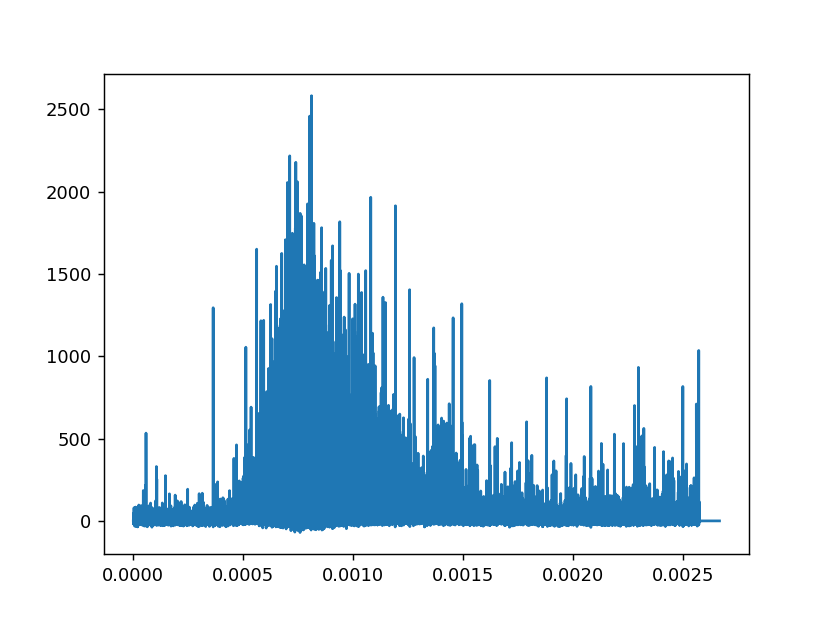

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from pathlib import Path
import argparse
import sys
import h5py
import time as ti



#-------------------------------------------------------
#=======================================================
#-------------------------------------------------------

DATABASE = Path('/eos/project/dblm/TZ76/VFC/')
dBLMFile = list(DATABASE.glob('blmed_tcp_b2_ch0_20180930_224752.hdf5'))


fileContent = h5py.File(dBLMFile[0], 'r')


t1 = ti.time()
time,rawData,turnFlags,bunchFlags = VFCParser(fileContent,turns=[100,130])
#time,rawData,turnFlags,bunchFlags = VFCParser(fileContent,turns=[300,400])
baseLine = signalBaseline(time,rawData,bunchFlags,turnFlags,stdThreshold=40)
print('Ellapsed time : %.3f' %(ti.time()-t1))



plt.figure()
plt.plot(time,rawData-baseLine)
#plt.plot(time,rawData.astype(float)-8000)
#plt.plot(time,baseLine-8000)

In [155]:
xData

array([0.00088943, 0.00088943, 0.00088944, 0.00088944, 0.00088944,
       0.00088944, 0.00088944, 0.00088944, 0.00088944, 0.00088945,
       0.00088945, 0.00088945, 0.00088945, 0.00088945, 0.00088945,
       0.00088946, 0.00088946, 0.00088946, 0.00088946, 0.00088946,
       0.00088946, 0.00088946, 0.00088947, 0.00088947])

In [170]:
print(popt)
print(p0Guess)


[ 7.79864762 80.03898383 81.03513594]
[9.135192307692305, 1, 88.94476923076923]


In [188]:
int(np.log10(12.3e4))

5

In [3]:
import scipy.optimize as so


def morseDecay(x,A,B1,B2,C):
    return A*(1-(1-np.exp(-B1*(x-C)))*(1-np.exp(-B2*(x-C))))

def exp_decay(x,A,B,C):
    return A*np.exp(-B*(x-C))

def fitBunch(x,y,nPoints = 100,):


    # Helping the fitting tool by rescaling the data
    # And keeping only after the rising edge
    riseIndex = 2 + np.argmax(np.diff(np.diff(y)))
    x0 = x[0]
    scaling = 10**(-int(np.log10(x[-1]-x[0])))
    x = scaling*(x[riseIndex:]-x0)
    y = y[riseIndex:]
    
    plt.plot(x/scaling + x0,y,':',color='C1')
    
     
    
    p0Guess = [np.max(y),1,1,x[np.argmax(y)]]
    lowBound = [p0Guess[0],1e-1,1e-1,p0Guess[3]-5*np.mean(np.diff(x))]
    highBound = [2*p0Guess[0],1e2,1e2,p0Guess[3]+5*np.mean(np.diff(x))]
    popt, pcov = so.curve_fit(morseDecay, x, y, p0=p0Guess,bounds=(lowBound, highBound))
    
    xFit = np.linspace(x[0]-5*np.mean(np.diff(x)),x[-1]+40*np.mean(np.diff(x)),nPoints)/scaling
    yFit = morseDecay(xFit, popt[0],popt[1]*scaling,popt[2]*scaling,popt[3]/scaling)
    yFit[yFit<0] = 0
    
    if np.any(np.array(popt)==np.array(lowBound)) or np.any(np.array(popt)==np.array(highBound)):
        print('WARNING, BOUND USED IN FIT')

    return xFit+x0,yFit

def fitOverlap(x,y,nPoints = 100,):

    
#def exp_decay(x, a,b,c):
 #   return a*np.exp(-(x-b)/c)
#
    # Helping the fitting tool by rescaling the data
    # And keeping only after the rising edge
    startIndex = np.argmax(y) + 5
    x0 = x[0]
    scaling = 10**(-int(np.log10(x[-1]-x[0])))
    x = scaling*(x[startIndex:]-x0)
    y = y[startIndex:]
    
    plt.plot(x/scaling + x0,y,'o',color='C1')
    
     
    
    p0Guess = [np.max(y),1,x[np.argmax(y)]]
    lowBound = [0.9*p0Guess[0],1e-1,p0Guess[2]-2*np.mean(np.diff(x))]
    highBound = [1.2*p0Guess[0],1e3,p0Guess[2]+2*np.mean(np.diff(x))]
    popt, pcov = so.curve_fit(exp_decay, x, y, p0=p0Guess,bounds=(lowBound, highBound))

    
    xFit = np.linspace(x[0]-2*np.mean(np.diff(x)),x[-1]+40*np.mean(np.diff(x)),nPoints)/scaling
    yFit = exp_decay(xFit, popt[0],popt[1]*scaling,popt[2]/scaling)
    yFit[yFit<0] = 0
    
    if np.any(np.array(popt)==np.array(lowBound)) or np.any(np.array(popt)==np.array(highBound)):
        print('WARNING, BOUND USED IN FIT')

    return xFit+x0,yFit


t1 = ti.time()
fileContent = h5py.File(dBLMFile[0], 'r')
time,rawData,turnFlags,bunchFlags = VFCParser(fileContent,turns=[100,130])
baseLine = signalBaseline(time,rawData,bunchFlags,turnFlags,stdThreshold=40)
fileContent.close()
print('Ellapsed time : %.3f' %(ti.time()-t1))



start = 578131
stop = start+225

corrected = rawData-baseLine

xData = time[start:stop]
yData = corrected[start:stop]

bunchFlagsIndex = np.arange(len(xData))[bunchFlags[start:stop].astype(bool)]

plt.figure()
plt.plot(xData,yData,'o')
for xBunch,yBunch in zip(np.split(xData,bunchFlagsIndex)[1:-1],np.split(yData,bunchFlagsIndex)[1:-1]):

    xFitted,yFitted = fitFINAL(xBunch,yBunch,nPoints = 1000)
    plt.plot(xFitted,yFitted,color='C3')
    
    #testX,testY = fitBunch(xBunch,yBunch,nPoints = 1000)
    #plt.plot(testX,testY,color='C3')
    
    #testX,testY = fitOverlap(xBunch,yBunch,nPoints = 100)
    #plt.plot(testX,testY,color='C4')
    
    
    #testX,testY = fitMoyal(xBunch,yBunch,nPoints = 1000)
    #plt.plot(testX,testY,color='C5')

plt.vlines(xData[bunchFlagsIndex],0,800)
#plt.figure()
#plt.plot(xData,yData)
#plt.vlines(xData[bunchFlagsIndex],0,800)
#plt.plot(xData,yData,':')
#plt.plot(testX,testY)
#plt.plot(time[start:stop+100],bunchFlags*100)



NameError: name 'VFCParser' is not defined

In [21]:
np.where(xData ==xData[xData>0.00314322][0])

(array([2043094]),)

Ellapsed time : 0.540


<IPython.core.display.Javascript object>


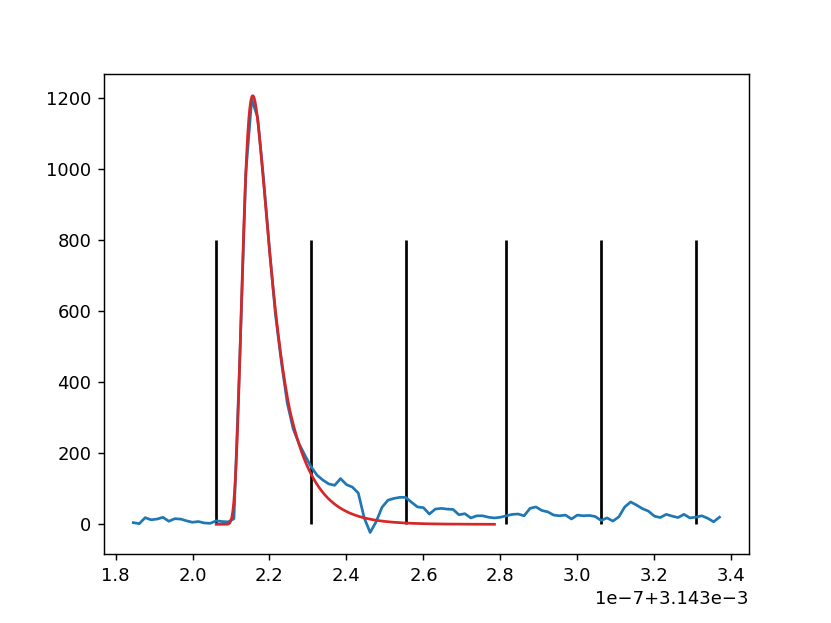

Raw integration : 14.81224
Fitted Integration : 12.95614


In [215]:

def moyalDist(x,A,mu,sigma1,sigma2):
    return A*np.exp(-(x-mu)/(2*sigma1) - np.exp(-(x-mu)/sigma2)/2)/np.exp(-1/2)

def expDecay(x,A,mu,sigma):
    return A*np.exp(-sigma*(x-mu))


    
def fitFINAL(x,y,nPoints = 100,):
    # Getting the index of the rising part (Moyal distribution) and the falling part (Exponential)
    riseIndex = 2 + np.argmax(np.diff(np.diff(y)))
    fallIndex = np.argmax(y) + 5
    
    
    # Re-scaling the data to help the fitting tool
    x0 = x[0]
    scaling = 10**(-int(np.log10(x[-1]-x[0])))
    x = scaling*(x-x0)
    xSpacing = np.mean(np.diff(x))
    
    
    
    # Fitting Moyal distribution
    xTemp = x[riseIndex:]
    yTemp = y[riseIndex:]
    p0Guess = [np.max(yTemp),xTemp[np.argmax(yTemp)],1,1]
    lowBound = [0.1*p0Guess[0],p0Guess[1]-5*xSpacing,1e-2,1e-2]
    highBound = [10*p0Guess[0],p0Guess[1]+5*xSpacing,1e2,1e2]
    poptMoyal,_ = so.curve_fit(moyalDist, xTemp, yTemp, p0=p0Guess,bounds=(lowBound, highBound))

   
    # Fitting the expontential
    xTemp = x[fallIndex:]
    yTemp = y[fallIndex:]
    p0Guess = [np.max(yTemp),xTemp[np.argmax(yTemp)],1]
    lowBound = [0.5*p0Guess[0],p0Guess[1]-5*xSpacing,1e-2]
    highBound = [1.5*p0Guess[0],p0Guess[1]+5*xSpacing,1e2]
    poptExp,_ = so.curve_fit(expDecay, xTemp, yTemp, p0=p0Guess,bounds=(lowBound, highBound))
    
    
    xFit = np.linspace(x[0],x[-1]+2*len(x)*xSpacing,nPoints)
    
    yMoyal = moyalDist(xFit, *poptMoyal)
    yExp = expDecay(xFit, *poptExp)
    
    expRegion = (xFit>x[fallIndex])&(yExp>yMoyal)
    
    yFit = yMoyal
    yFit[expRegion] = yExp[expRegion]
    yFit[yFit<0] = 0
    
    return xFit/scaling + x0,yFit




t1 = ti.time()
fileContent = h5py.File(dBLMFile[0], 'r')
time,rawData,turnFlags,bunchFlags = VFCParser(fileContent,turns=[300,400])
baseLine = signalBaseline(time,rawData,bunchFlags,turnFlags,stdThreshold=40)
fileContent.close()
print('Ellapsed time : %.3f' %(ti.time()-t1))



start = 2043070
stop = start+100

corrected = rawData-baseLine

xData = time[start:stop]
yData = corrected[start:stop]

bunchFlagsIndex = np.arange(len(xData))[bunchFlags[start:stop].astype(bool)]


xTest = np.concatenate(np.split(xData,bunchFlagsIndex)[1:4])
yTest = np.concatenate(np.split(yData,bunchFlagsIndex)[1:4])




xBunch = np.split(xData,bunchFlagsIndex)[1]
yBunch = np.split(yData,bunchFlagsIndex)[1]

plt.figure()
plt.plot(xData,yData)
plt.vlines(xData[bunchFlagsIndex],0,800)

xFitted,yFitted = fitFINAL(xBunch,yBunch,nPoints = 1000)
plt.plot(xFitted,yFitted,color='C3')

print('Raw integration : %.5f' %(np.trapz(yTest,1e6*xTest)))
print('Fitted Integration : %.5f' %(np.trapz(yFitted,1e6*xFitted)))


In [207]:
(14.81-12.95)/14.81

0.12559081701553013

<IPython.core.display.Javascript object>


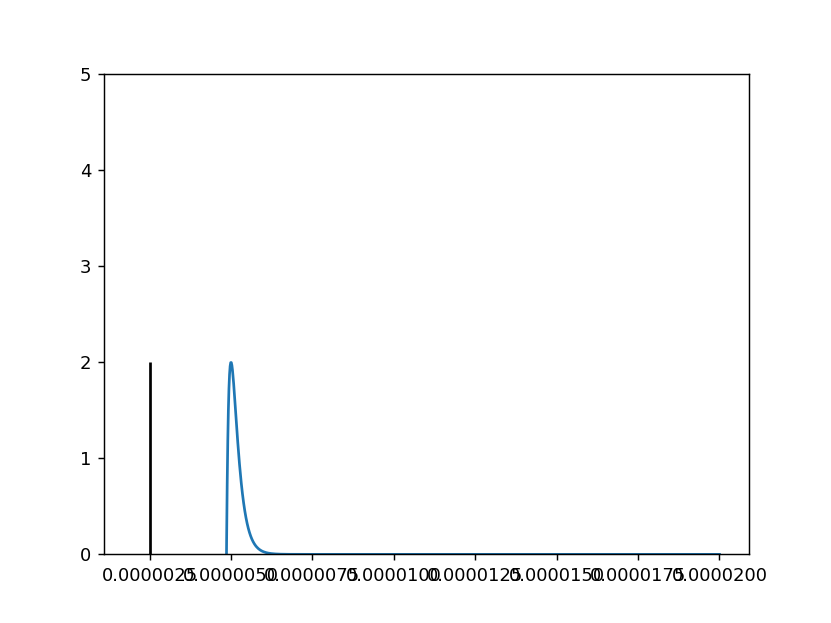

(0, 5)

In [132]:


def morseDecay(x,A,B,C):
    return A*(1-(1-np.exp(-B*(x-C)))**2)



x = np.linspace(2,20,1000)
plt.figure()
plt.plot(x*1e-6,morseDecay(x*1e-6,2,5*1e6,5*1e-6))
plt.vlines(2.5*1e-6,0,2)
plt.ylim([0,5])

<IPython.core.display.Javascript object>


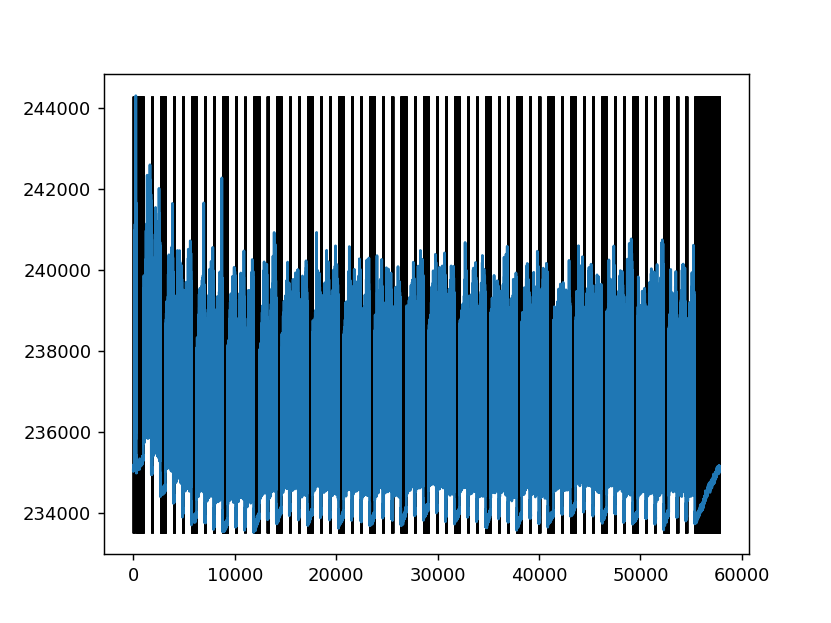

In [376]:
data = rawData
stdThreshold  = 50
#####



plt.figure()
plt.plot(fillSignal)
plt.vlines(gapIndex,np.min(fillSignal),np.max(fillSignal))




In [344]:
gapIndex = getGaps(data,bunchFlags,turnFlags,stdThreshold=50)

bunchFlagsIndex = np.arange(len(data))[bunchFlags.astype(bool)]
turnFlagsIndex = np.arange(len(data))[turnFlags.astype(bool)]
allGaps = np.repeat(turnFlagsIndex[:-1],len(gapIndex)) + np.tile(gapIndex,len(turnFlagsIndex[:-1]))

binLength = np.max(np.diff(bunchFlagsIndex))
baseLine = [subsection if len(subsection)<3*binLength else np.interp(np.arange(len(subsection)),[0,len(subsection)],[subsection[0],subsection[1]]) for subsection in np.split(rawData,allGaps)]


#np.linspace(0,1,len(subsection))*(subsection[-1]-subsection[0])+subsection[0]

<IPython.core.display.Javascript object>


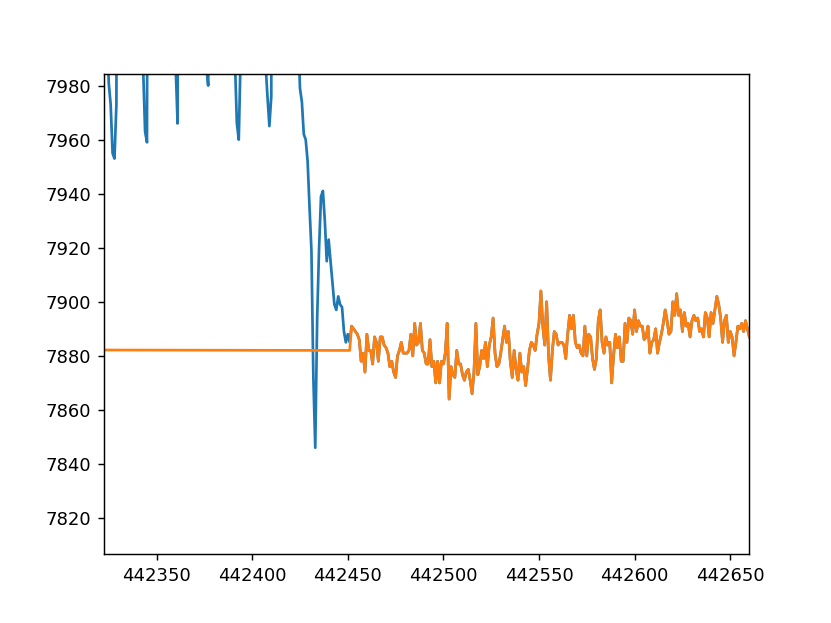

In [345]:
plt.figure()
plt.plot(rawData)
plt.plot(np.concatenate(baseLine))
#plt.vlines(allGaps,np.min(rawData),np.max(rawData))
#plt.vlines(turnFlagsIndex,np.min(rawData),np.max(rawData),color='r')


In [239]:
bucketInfo[:-1]


array([[5.70327483e+00, 8.02681250e+03],
       [4.38541149e+00, 8.01905882e+03],
       [5.70635611e+00, 8.02875000e+03],
       ...,
       [4.28250438e+00, 8.05968750e+03],
       [5.02765788e+00, 8.06081250e+03],
       [5.43982495e+00, 8.06123529e+03]])

<IPython.core.display.Javascript object>


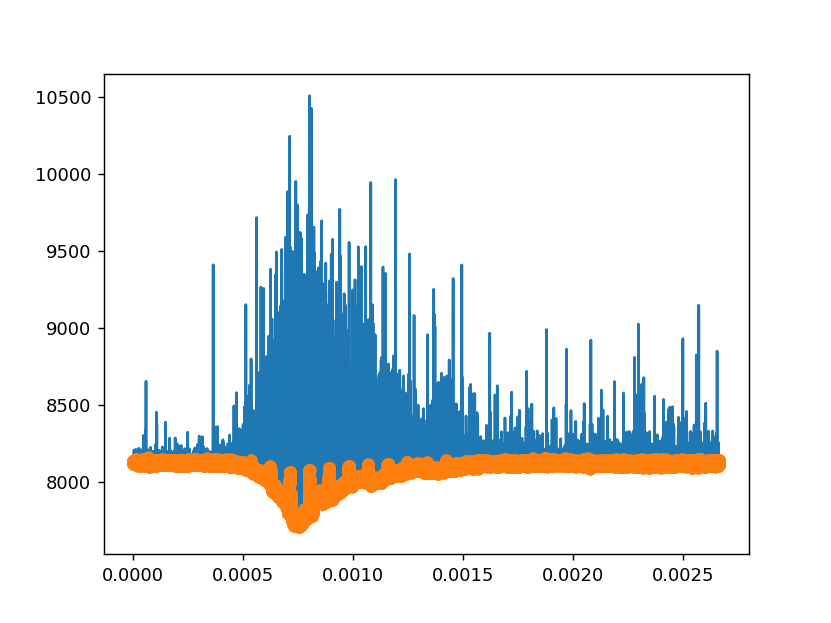

In [272]:
%matplotlib notebook 
plt.figure()
plt.plot(time,rawData)
plt.plot(baseLineX,baseLineY,'-o')
plt.show()

<IPython.core.display.Javascript object>


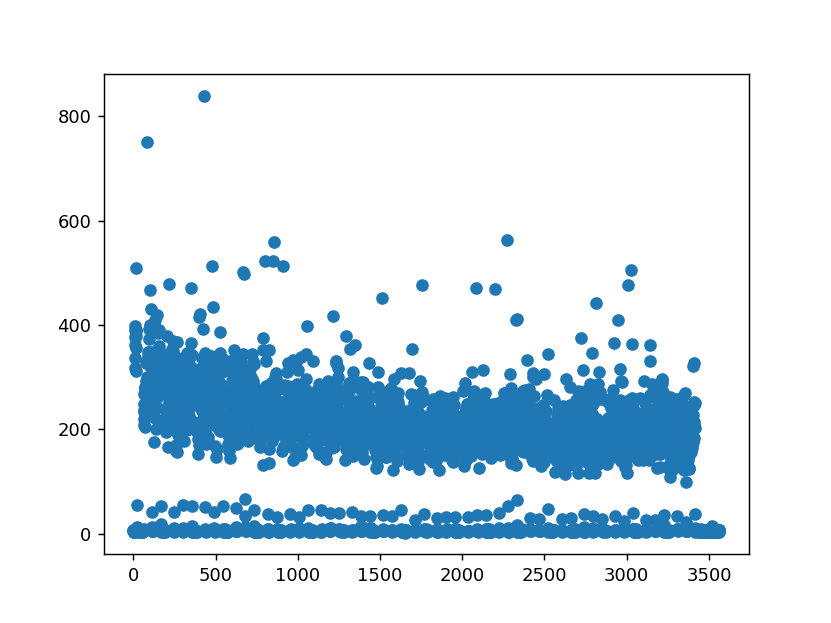

In [252]:
test = [(np.std(subsection),np.mean(subsection)) for subsection in np.split(rawData,np.arange(len(rawData))[bunchFlags.astype(bool)])]
    
a,b = list(list(zip(*test)))
plt.figure()
plt.plot(list(a),'o')

In [92]:
np.arange(1,cst.LHC_N_BUCKETS+1)[]

array([    1,     2,     3, ..., 35638, 35639, 35640])

<IPython.core.display.Javascript object>


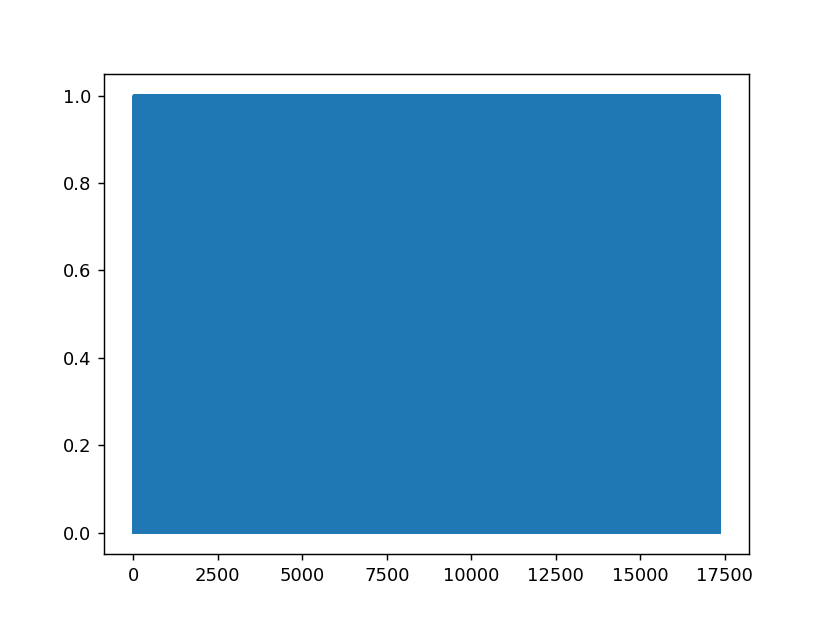

In [94]:
plt.figure()
plt.plot(bunchFlags)

In [ ]:

def levyDist(x,A,mu,sigma):
    if np.all(x<=mu):
        return np.zeros(len(x))
    else:
        return A*np.sqrt(sigma)*np.exp(-sigma/(2*(x-mu)))/(x-mu)**(3/2)




def fitLevy(x,y,nPoints = 100,):


    # Helping the fitting tool by rescaling the data
    # And keeping only after the rising edge
    riseIndex = 2 + np.argmax(np.diff(np.diff(y)))
    x0 = x[0]
    scaling = 10**(-int(np.log10(x[-1]-x[0])))
    x = scaling*(x[riseIndex:]-x0)
    y = y[riseIndex:]
    
    plt.plot(x/scaling + x0,y,':',color='C1')
    
     
    
    p0Guess = [np.max(y),0,1]
    lowBound = [1e-2*p0Guess[0],p0Guess[1]-50*np.mean(np.diff(x)),1e-4]
    highBound = [1e2*p0Guess[0],p0Guess[1]+50*np.mean(np.diff(x)),1e4]
    popt, pcov = so.curve_fit(levyDist, x, y, p0=p0Guess,bounds=(lowBound, highBound))
    
    
    print(p0Guess)
    print(popt)
    xFit = np.linspace(x[0]-5*np.mean(np.diff(x)),x[-1]+40*np.mean(np.diff(x)),nPoints)/scaling
    yFit = levyDist(xFit, popt[0]/scaling,popt[1]/scaling,popt[2]/scaling)
    #yFit[yFit<0] = 0
    
    #if np.any(np.array(popt)==np.array(lowBound)) or np.any(np.array(popt)==np.array(highBound)):
    #    print('WARNING, BOUND USED IN FIT')

    return xFit+x0,yFit


def fitMoyal(x,y,nPoints = 100,):


    # Helping the fitting tool by rescaling the data
    # And keeping only after the rising edge
    riseIndex = 2 + np.argmax(np.diff(np.diff(y)))
    x0 = x[0]
    scaling = 10**(-int(np.log10(x[-1]-x[0])))
    x = scaling*(x[riseIndex:]-x0)
    y = y[riseIndex:]
    
    plt.plot(x/scaling + x0,y,':',color='C1')
    
     
    
    p0Guess = [np.max(y),x[np.argmax(y)],1,1]
    lowBound = [0.1*p0Guess[0],p0Guess[1]-5*np.mean(np.diff(x)),1e-2,1e-2]
    highBound = [10*p0Guess[0],p0Guess[1]+5*np.mean(np.diff(x)),1e2,1e2]
    popt, pcov = so.curve_fit(moyalDist, x, y, p0=p0Guess,bounds=(lowBound, highBound))
    
    
    #print(p0Guess)
    #print(popt)
    xFit = np.linspace(x[0]-5*np.mean(np.diff(x)),x[-1]+40*np.mean(np.diff(x)),nPoints)/scaling
    yFit = moyalDist(xFit, popt[0],popt[1]/scaling,popt[2]/scaling,popt[3]/scaling)
    yFit[yFit<0] = 0
    
    if np.any(np.array(popt)==np.array(lowBound)) or np.any(np.array(popt)==np.array(highBound)):
        print('WARNING, BOUND USED IN FIT')

    return xFit+x0,yFit


t1 = ti.time()
fileContent = h5py.File(dBLMFile[0], 'r')
time,rawData,turnFlags,bunchFlags = VFCParser(fileContent,turns=[300,400])
baseLine = signalBaseline(time,rawData,bunchFlags,turnFlags,stdThreshold=40)
fileContent.close()
print('Ellapsed time : %.3f' %(ti.time()-t1))



start = 2043070
stop = start+100

corrected = rawData-baseLine

xData = time[start:stop]
yData = corrected[start:stop]

bunchFlagsIndex = np.arange(len(xData))[bunchFlags[start:stop].astype(bool)]
#xBunch = np.concatenate(np.split(xData,bunchFlagsIndex)[1:4])
#yBunch = np.concatenate(np.split(yData,bunchFlagsIndex)[1:4])
xBunch = np.concatenate((np.split(xData,bunchFlagsIndex)[1],np.split(xData,bunchFlagsIndex)[2][:5]))
yBunch = np.concatenate((np.split(yData,bunchFlagsIndex)[1],np.split(yData,bunchFlagsIndex)[2][:5]))
#xBunch = np.split(xData,bunchFlagsIndex)[1]
#yBunch = np.split(yData,bunchFlagsIndex)[1]

plt.figure()
plt.plot(xData,yData,'o')
plt.vlines(xData[bunchFlagsIndex],0,800)


testX,testY = fitBunch(xBunch,yBunch,nPoints = 1000)
#plt.plot(testX,testY,color='C3')
#plt.plot(testX,moyalDist(testX,1200/2,0.003143215,3e-8,0.1e-9))


testX,testY = fitMoyal(xBunch,yBunch,nPoints = 1000)
plt.plot(testX,testY,color='C4')

#test = np.linspace(0,100,1000)
#plt.figure()


Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/matplotlib/backends/backend_nbagg.py", line 241, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/matplotlib/_pylab_helpers.py", line 58, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


Ellapsed time : 0.379


<IPython.core.display.Javascript object>


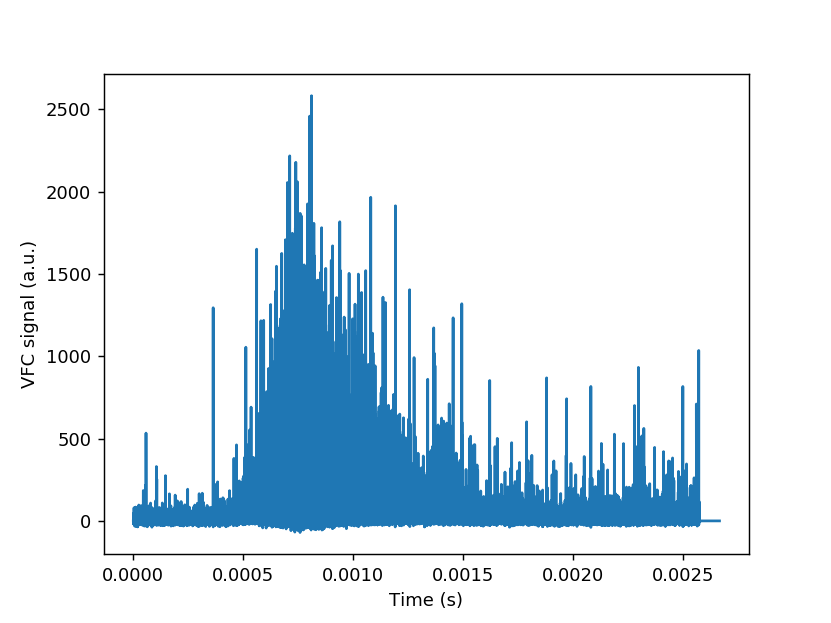

In [3]:
%matplotlib notebook
%run ../UFO_dBLM/test.py


#gapIndex = sp.getGaps(data.signal,data.bunchFlags,data.turnFlags,stdThreshold=50)
#bunchFlagsIndex = np.arange(len(data.signal))[data.bunchFlags.astype(bool)]
#turnFlagsIndex = np.arange(len(data.signal))[data.turnFlags.astype(bool)]
#allGaps = np.repeat(turnFlagsIndex[:-1],len(gapIndex)) + np.tile(gapIndex,len(turnFlagsIndex[:-1]))
allGaps = sp.getGaps(data.signal,data.bunchFlags,data.turnFlags)

#plt.figure()
#plt.plot(data.time,data.signal)
#plt.vlines(data.time[allGaps],np.min(data.signal),np.max(data.signal))

